In [2]:
from dataset import BufferedGeoDataLoader
import xarray as xr
import numpy as np
from tqdm import tqdm
import time

import pytorch_lightning as pl

In [2]:
geodata = BufferedGeoDataLoader(fold_id=0, num_wokers=8)

In [3]:
from project.pl_models.tcn_model import TemporalConvNetPL
from project.utils.torch_utils import count_parameters

In [4]:
tcn = TemporalConvNetPL(
    num_inputs=geodata.num_features_hourly, num_geofactors=geodata.num_features_static, num_outputs=1, num_hidden=32, num_layers=3, dropout=0.2, static_dropout=0.2, kernel_size=3,
    tasks='fvc', lr=0.001, weight_decay=0.001)

In [5]:
trainer = pl.Trainer(accelerator='gpu', devices=[7])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(tcn, datamodule=geodata)

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name             | Type            | Params
-----------------------------------------------------
0 | loss_fn          | RegressionLoss  | 0     
1 | encode_static    | FeedForward     | 2.5 K 
2 | flatten_time     | Transform       | 0     
3 | to_sequence_last | Transform       | 0     
4 | tcn              | TemporalConvNet | 18.8 K
5 | tcn_mean         | TemporalConvNet | 7.5 K 
6 | tcn_var          | TemporalConvNet | 7.5 K

Sanity Checking: 0it [00:00, ?it/s]

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:178: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:132: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


tensor([[[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        ...,

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]]], device='cuda:7')
tensor([[[3.4539e+16],
         [3.4539e+16],

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:132: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [15]:
tcn(batch.f_hourly, batch.f_static)

tensor([[[0.0125],
         [0.0167],
         [0.0180],
         ...,
         [0.0172],
         [0.0154],
         [0.0175]],

        [[0.0130],
         [0.0169],
         [0.0162],
         ...,
         [0.0173],
         [0.0167],
         [0.0143]],

        [[0.0127],
         [0.0160],
         [0.0170],
         ...,
         [0.0163],
         [0.0171],
         [0.0157]],

        ...,

        [[0.0123],
         [0.0167],
         [0.0166],
         ...,
         [0.0155],
         [0.0182],
         [0.0174]],

        [[0.0140],
         [0.0176],
         [0.0186],
         ...,
         [0.0180],
         [0.0176],
         [0.0169]],

        [[0.0123],
         [0.0161],
         [0.0179],
         ...,
         [0.0177],
         [0.0173],
         [0.0165]]], grad_fn=<PermuteBackward0>)

In [6]:
train_loader = geodata.train_dataloader()

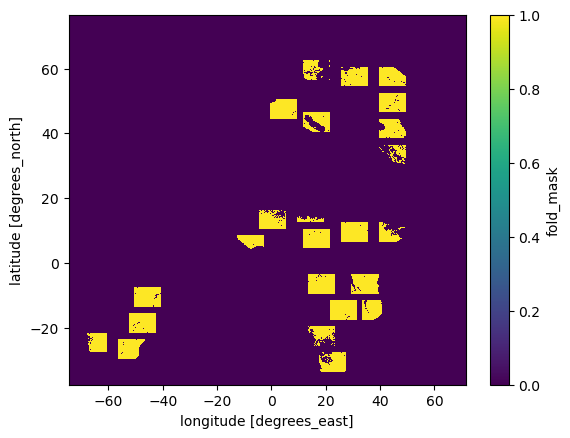

In [7]:
train_loader.dataset.mask.plot()

In [8]:
target = xr.full_like(train_loader.dataset.mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        time.sleep(0.5)
except:
    traceback.print_exc()

  0%|                                       | 2/2213 [00:57<17:45:35, 28.92s/it]
Traceback (most recent call last):
  File "/raid/scratch/tmp/ipykernel_46646/161158528.py", line 5, in <module>
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1282, in _get_data
    success, data = self._try_get_data()
  File "/Net/Groups/BGI/peopl

In [11]:
batch.f_hourly.shape

torch.Size([50, 24, 1000, 4])

In [12]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [13]:
batch.f_static.shape

torch.Size([50, 6])

In [14]:
b.f_static.shape

torch.Size([50, 6])

RuntimeError: Given groups=1, weight of size [32, 4, 3], expected input[50, 24000, 4] to have 4 channels, but got 24000 channels instead

In [19]:
import matplotlib.pyplot as plt

In [44]:
b.f_hourly = b.f_hourly.view(b.f_hourly.shape[0], -1, b.f_hourly.shape[-1])

AttributeError: can't set attribute

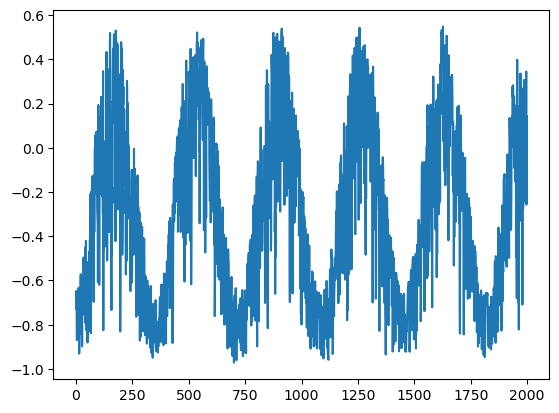

In [43]:
plt.plot(br[49, :2000, 1])

In [14]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [5]:
count_parameters(tcn)

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| feedforward_static.model.linear00.weight |    192     |
|  feedforward_static.model.linear00.bias  |     32     |
| feedforward_static.model.linear01.weight |    256     |
|  feedforward_static.model.linear01.bias  |     8      |
|           tcn.tcn.0.conv1.bias           |     32     |
|         tcn.tcn.0.conv1.weight_g         |     32     |
|         tcn.tcn.0.conv1.weight_v         |    384     |
|           tcn.tcn.0.conv2.bias           |     32     |
|         tcn.tcn.0.conv2.weight_g         |     32     |
|         tcn.tcn.0.conv2.weight_v         |    3072    |
|     tcn.tcn.0.res.downsample.weight      |    152     |
|      tcn.tcn.0.res.downsample.bias       |     38     |
|           tcn.tcn.1.conv1.bias           |     32     |
|         tcn.tcn.1.conv1.weight_g         |     32     |
|         tcn.

19347

In [3]:
tcn

TemporalConvNetPL(
  (feedforward_static): FeedForward(
    (model): Sequential(
      (linear00): Linear(in_features=6, out_features=32, bias=True)
      (dropout00): Dropout(p=0.2, inplace=False)
      (activation00): ReLU()
      (linear01): Linear(in_features=32, out_features=8, bias=True)
      (dropout01): Dropout(p=0.2, inplace=False)
      (activation01): Tanh()
    )
  )
  (tcn): TemporalConvNet(
    (to_sequence_last): Transform()
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (res): Residual(
          (downsample): Conv1d(4, 38, kernel_size=(1,), stride=(1,))
        )
        (relu): ReLU()
      )
      (1): Tem

In [ ]:
import time

class Dataset(object):
    def __init__(self, max_items = 5):
        self.max_items = max_items
        self.chunks = []

    def add_item(self, x):
        self.chunks.appendd(x)

    def get_item(self, n):
        if len(self.chunks) >= 0
            result = [self.chunks.pop() for _ in range(n)]
        else:
            raise StopIteration

        time.sleep(0.1)

        return 


In [61]:
import threading
import queue

class BackgroundGenerator(threading.Thread):
    def __init__(self, generator):
        threading.Thread.__init__(self)
        self.queue = queue.Queue(1)
        self.generator = generator
        self.daemon = True
        self.start()

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
            next_item = self.queue.get()
            if next_item is None:
                 raise StopIteration
            return next_item

In [62]:
def generate(n):
    for i in range(n):
        yield i

In [64]:
bgen = BackgroundGenerator(generator=generate(10))

In [ ]:
bgen.next()

0

In [69]:
bgen.run()

KeyboardInterrupt: 

Consumer: Running
Producer: Running
>put value 0 (1 total)
>put value 1 (2 total)
>get value 0 (1 total)
>put value 2 (2 total)>got 0

>put value 3 (3 total)
>put value 4 (4 total)
>put value 5 (5 total)
>get value 1 (4 total)
>got 1
>put value 6 (5 total)
>get value 2 (4 total)
>got 2
>put value 7 (5 total)
>get value 3 (4 total)
>got 3>put value 8 (5 total)

>get value 4 (4 total)
>got 4>put value 9 (5 total)

Producer: Done
>get value 5 (4 total)
>got 5
>get value 6 (3 total)
>got 6
>get value 7 (2 total)
>got 7
>get value 8 (1 total)
>got 8
>get value 9 (0 total)
>got 9


KeyboardInterrupt: 

In [76]:
# SuperFastPython.com
# example of using the simple queue among processes
from time import sleep
from random import random
from multiprocessing import Process
from multiprocessing import SimpleQueue
 
# generate work
def producer(queue):
    print('Producer: Running', flush=True)
    # generate work
    for i in range(10):
        # generate a value
        value = random()
        # block
        #sleep(value)
        # add to the queue
        print('Put value')
        queue.put(value)
    # all done
    queue.put(None)
    print('Producer: Done', flush=True)
 
# consume work
def consumer(queue):
    print('Consumer: Running', flush=True)
    # consume work
    while True:
        # get a unit of work
        item = queue.get()
        # check for stop
        if item is None:
            break
        # report
        print(f'>got {item}', flush=True)
        sleep(1)
    # all done
    print('Consumer: Done', flush=True)
 
# create the shared queue
queue = SimpleQueue()
# start the consumer
consumer_process = Process(target=consumer, args=(queue,))
consumer_process.start()
# start the producer
producer_process = Process(target=producer, args=(queue,))
producer_process.start()
# wait for all child processes to finish
producer_process.join()
consumer_process.join()

Consumer: Running
Producer: Running
Put value
>got 0.5167574710624812Put value

Put value
Put value
Put value
Put value
Put value
Put value
Put value
Put value
Producer: Done
>got 0.8092434984658852
>got 0.31689718979925574
>got 0.820357973428891
>got 0.3068956683358398
>got 0.3917735942309919
>got 0.7456238883130152
>got 0.6774774386586543
>got 0.5731500276208481
>got 0.27763739356529193
Consumer: Done


In [73]:
queue

AttributeError: 'SimpleQueue' object has no attribute 'qsize'

In [60]:

import torch
from torch.utils.data import IterableDataset, DataLoader
import time
import numpy as np


In [61]:
# SuperFastPython.com
# example of using the simple queue among processes
import torch.multiprocessing as mpl
from torch.multiprocessing import Process, SimpleQueue
from time import sleep
from random import random

#n_enqueued = mpl.Value('i', 0)

# generate work
def producer(queue, n_enqueued):
    print('Producer: Running', flush=True)
    # generate work
    current_value = 0
    exit = False
    while True:
        if exit:
            break

        if n_enqueued.value < 5:
            # add to the queue
            queue.put(current_value)
            with n_enqueued.get_lock():
                n_enqueued.value += 1
                print(f'>put value {current_value} ({n_enqueued.value} total)')

            current_value += 1

            if current_value >= 10:
                exit = True

        else:
            sleep(0.5)

    # all done
    queue.put(None)
    print('Producer: Done', flush=True)


In [64]:
class Buffer(object):
    def __init__(self):
        self.queue = SimpleQueue()
        self.n_enqueued = mpl.Value('i', 0)

        self.producer_process = Process(target=producer, args=(self.queue, self.n_enqueued,))
        self.producer_process.start()

    def next(self):
        while True:
            if self.n_enqueued.value < 1:
                sleep(1)
                continue

            with self.n_enqueued.get_lock():
                self.n_enqueued.value -= 1

            value = self.queue.get()
            print(f'>get value {value} ({self.n_enqueued.value} total)')
            return value

    def terminate(self):
        self.producer_process.join()


class Data(IterableDataset):
    def __init__(self):
        super().__init__()

    def __iter__(self):
        queue = SimpleQueue()
        buffer = Buffer()

        while True:
            el = buffer.next()

            if el is None:
                buffer.terminate()
                break

            print(el)

            yield el


data = Data()
dataloader = DataLoader(data, prefetch_factor=2, num_workers=1)


In [65]:
if __name__ == '__main__':
    for d in dataloader:
        sleep(0.5)
        print(d)

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data.append(next(self.dataset_iter))
  File "/raid/scratch/tmp/ipykernel_23727/3276945696.py", line 32, in __iter__
    buffer = Buffer()
  File "/raid/scratch/tmp/ipykernel_23727/3276945696.py", line 7, in __init__
    self.producer_process.start()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/multiprocessing/process.py", line 118, in start
    assert not _current_process._config.get('daemon'), \
AssertionError: daemonic processes are not allowed to have children


In [28]:
import torch.multiprocessing as mp

In [36]:
class A(object):
    def __init__(self):
        self.n = 0

    def increase(self):
        self.n += 1

In [37]:
processes = []
aaa = []
for _ in range(2):
    a = A()

    aaa.append(a)
    process = mp.Process(target=a.increase)
    process.start()
    processes.append(process)

for process in processes:
    process.join()


In [39]:
aaa[1].n

0

In [41]:
import xarray as xr
import numpy as np

In [53]:
mask = xr.DataArray(np.random.choice(2, size=(10, 10)), dims=['lat', 'lon'], coords={'lat': np.arange(10), 'lon': np.arange(10)})

In [67]:
np.argwhere(mask.stack(sample=('lat', 'lon')).values).squeeze()

array([ 0,  2,  3,  5,  7, 10, 12, 15, 16, 17, 18, 20, 21, 22, 26, 27, 28,
       30, 32, 33, 37, 42, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58,
       62, 64, 65, 66, 67, 69, 73, 76, 77, 79, 80, 84, 86, 87, 89, 91, 93,
       95, 98, 99])

In [54]:
mask_flat = mask.stack(sample=('lat', 'lon')).reset_coords()
mask_flat

ValueError: cannot reset_coords with drop=False on an unnamed DataArrray

In [92]:
m = mask_flat.where(mask_flat, drop=True)

In [93]:
m

<xarray.DataArray (sample: 52)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])
Coordinates:
  * sample   (sample) object MultiIndex
  * lat      (sample) int64 0 0 0 0 1 1 1 1 1 1 2 2 ... 7 7 7 8 8 8 8 8 8 8 8 9
  * lon      (sample) int64 0 1 4 7 0 1 2 4 5 6 0 3 ... 6 8 9 1 2 4 5 6 7 8 9 4

In [68]:
np.random.shuffle([1])

In [3]:
import torch.multiprocessing as mp
import queue

In [8]:
q = mp.Manager().Queue()

In [9]:
try:
    q.get(block=False)
    print('try')
except queue.Empty:
    print('empty')

empty


: 

In [1]:
import xarray as xr

In [2]:
order = xr.open_dataset('../order.nc')
count = xr.open_dataset('../count.nc')

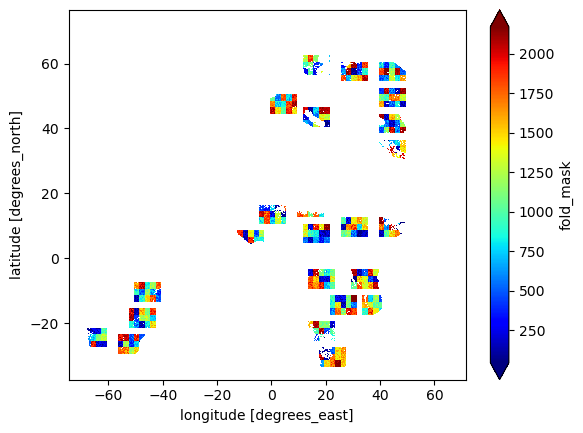

In [4]:
order.fold_mask.plot(robust=True, cmap='jet')

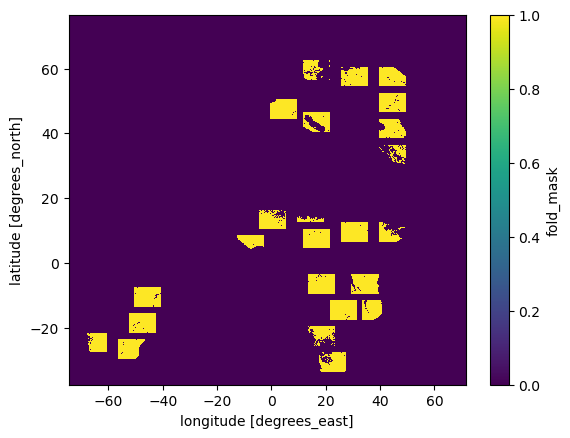

In [3]:
count.fold_mask.plot()

In [4]:
mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr').fold_mask

In [5]:
mask = mask.chunk({'lat': -1, 'lon': -1})

In [7]:
mask = mask.load()

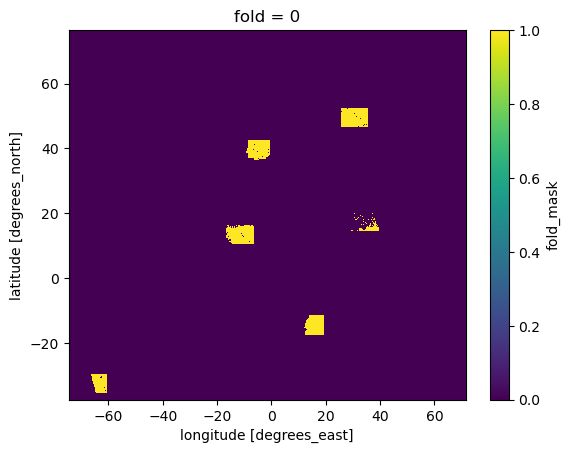

In [14]:
mask.isel(fold=0).plot()

In [33]:
import xarray as xr
import numpy as np
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr')

mask = ds.mask.load()
chunk_mask = (mask.coarsen(lat=20, lon=20).sum()) > 200
lat_min, lon_min = np.argwhere(chunk_mask.values)[0] * 20
lat_max, lon_max = (np.argwhere(chunk_mask.values)[0] + 1) * 20
mask  = mask.isel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).load()
data  = ds[['fvc']].isel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice(1000, 1100)).load()

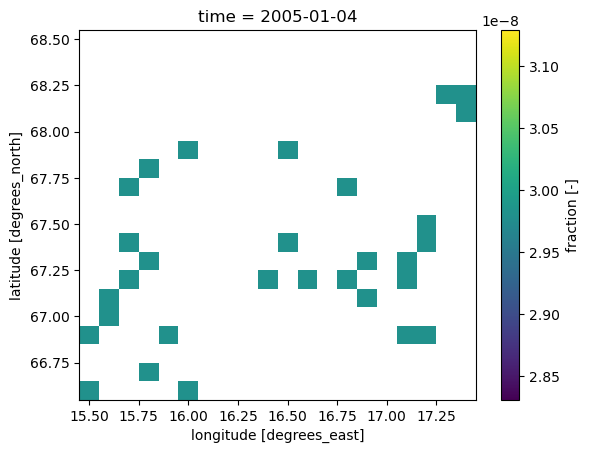

In [34]:
data.fvc.isel(time=-1).plot()

In [48]:
class DataChunk(object):
    """Defines a single chunk and how to retreive data from it."""
    def __init__(
            self,
            data: xr.Dataset,
            mask: xr.DataArray,
            shuffle: bool = False) -> None:

        data = data.load()
        mask = mask.load()

        mask = mask.stack(sample=('lat', 'lon')).reset_coords(drop=True).load()
        data = data.stack(sample=('lat', 'lon')).reset_coords(drop=True)
        self.data = data.where(mask, drop=True).load()

        self.shuffle = shuffle

        self.coords = self._get_coords()

        self._current_sample = 0

    def _get_coords(self):
        coords = np.arange(len(self.data.sample))
        if self.shuffle:
            np.random.shuffle(coords)
        return coords


In [49]:
dc = DataChunk(data=data, mask=mask)

In [50]:
dc.data.isel(sample=0).lat.item()

68.5

In [51]:
dc.data

<xarray.Dataset>
Dimensions:  (time: 100, sample: 273)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-27 2004-09-28 ... 2005-01-04
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.6 15.7 15.8 16.1 16.2 ... 17.1 17.2 17.3 17.4
Data variables:
    fvc      (time, sample) float32 2.98e-08 nan nan nan nan ... nan nan nan nan

In [37]:
dc.data

<xarray.Dataset>
Dimensions:  (time: 100, sample: 273)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-27 2004-09-28 ... 2005-01-04
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.6 15.7 15.8 16.1 16.2 ... 17.1 17.2 17.3 17.4
Data variables:
    fvc      (time, sample) float32 2.98e-08 nan nan nan nan ... nan nan nan nan

In [38]:
dc.mask

<xarray.DataArray 'mask' (sample: 400)>
array([False,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True,  True,  True, False, False,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
...
        True, False, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])
Coordinates:
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.5 15.6 15.7 15.8 15.9 ... 17.1 17.2 17.3 17.4

In [1]:
def iterate():
    i = 0
    try:
        while True:
            result = i
            i += 1
            if i == 5:
                return
            yield result
    finally:
        print('finally')

In [3]:
for j in range(2):
    for i in iterate():
        print(i)

0
1
2
3
finally
0
1
2
3
finally


In [5]:
from collections import namedtuple
from torch.utils.data import default_collate
import numpy as np

In [6]:
Test = namedtuple('Test', 'x coords')
Coords = namedtuple('Coords', 'lat lon')

In [10]:
test = [
    Test(x=np.random.normal(size=(5, 2)), coords=Coords(lat=1., lon=2.))
    for _ in range(2)
]
test

[Test(x=array([[-0.05169785, -1.19446625],
        [-0.02616812,  0.29265525],
        [-0.80453835, -1.31370333],
        [ 1.29728385, -0.2017546 ],
        [ 0.00385832,  1.04190332]]), coords=Coords(lat=1.0, lon=2.0)),
 Test(x=array([[-1.25719972, -1.56233856],
        [ 1.81261453,  0.03051929],
        [-0.33211487,  0.5905362 ],
        [ 1.5935525 ,  0.02801135],
        [ 0.8514032 ,  0.71317286]]), coords=Coords(lat=1.0, lon=2.0))]

In [12]:
default_collate(test).x.shape

torch.Size([2, 5, 2])

In [13]:
import torch

In [16]:
torch.load('../batch_66976.pkl')

EOFError: Ran out of input

In [10]:
import torch.multiprocessing as mp
from time import sleep

def worker():
    while True:
        print('Sleep for a bit')
        sleep(5)

def worker_loop():
    try:
        process = mp.Process(target=worker)
    finally:
        process.terminate()
        process.join()
